In [ ]:
%pip install --upgrade aicsimageio aicspylibczi>=3.0.5 dask>=2022.02 pyyaml==5.4.1
%pip install git+https://github.com/yfukai/BaSiCpy@jax_version

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.12.1 requires dask==2022.12.1, but you have dask 2023.3.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/yfukai/BaSiCpy (to revision jax_version) to /tmp/pip-req-build-z04c2q3_
  Running command git clone --filter=blob:none --quiet https://github.com/yfukai/BaSiCpy /tmp/pip-req-build-z04c2q3_
  Running command git checkout -b jax_version --track origin/jax_version
  Switched to a new branch 'jax_version'
  Branch 'jax_version' set up to track remote branch 'jax_version' from 'origin'.
  Resolved https://github.com/yfukai/BaSiCpy to commit d51ce5740b7f637a3aea943d42d4154434f48b39
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyprojec

In [ ]:
import xarray

xarray.__version__
import numpy as np
from os import path
import os
from aicsimageio import AICSImage
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion

# from cucim.skimage.morphology import binary_erosion, disk

from skimage.filters import threshold_multiotsu
from basicpy import BaSiC

# Load data

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DOrganoidfromNan/organoid_confocal.czi"
# assert path.isfile(file_path)
img = AICSImage(file_path, reconstruct_mosaic=False)
data = img.data

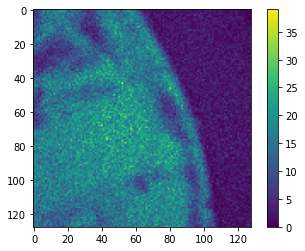

In [ ]:
plt.imshow(data[4, 1, 0, 10, :, :])
plt.colorbar()

In [ ]:
img_shadow_corrs = np.array(
    [
        data[:, :, c, :, :, :].reshape((data.shape[0] * data.shape[1], *data.shape[3:]))
        for c in range(data.shape[2])
    ]
)
print(img_shadow_corrs.shape)

(2, 640, 21, 128, 128)


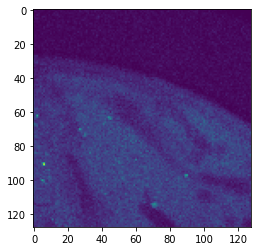

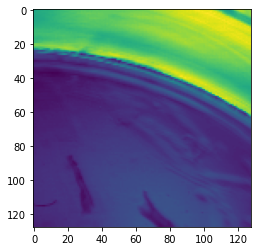

In [ ]:
plt.imshow(img_shadow_corrs[0, 100, 10])
plt.show()
plt.imshow(img_shadow_corrs[1, 100, 10])
plt.show()

# Create mask for shadow correction

In [ ]:
thresholds = [threshold_multiotsu(img_shadow_corrs[c]) for c in range(img.shape[2])]
print(thresholds)

[array([ 40, 118]), array([ 64, 135])]


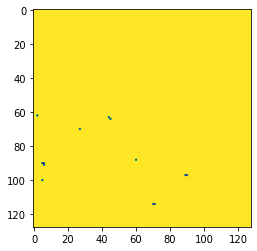

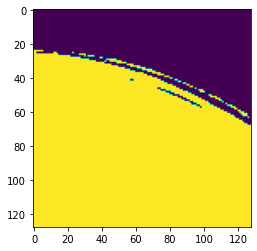

In [ ]:
plt.imshow((img_shadow_corrs[0] < thresholds[0][0])[100, 10])
plt.show()
plt.imshow((img_shadow_corrs[1] < thresholds[1][0])[100, 10])
plt.show()

In [ ]:
thresholded = img_shadow_corrs[1] < thresholds[1][0]
original_shape = thresholded.shape
print(original_shape)

(640, 21, 128, 128)


<ipython-input-11-ecd471318b57>:6: FutureWarning: `selem` is a deprecated argument name for `binary_erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  im = binary_erosion(im,selem=np.ones((1,3,3)))


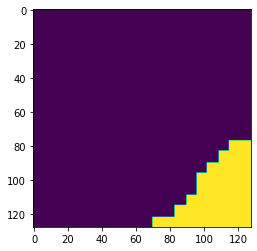

In [ ]:
i = 0


def erosion(im):
    im = resize(binary_erosion(im), (original_shape[2], 20, 20), anti_aliasing=False)
    im = binary_erosion(im, selem=np.ones((1, 3, 3)))
    im = resize(im, original_shape[1:], anti_aliasing=False)
    return im


im = erosion(thresholded[i, ...])
plt.imshow(im[10])

<ipython-input-11-ecd471318b57>:6: FutureWarning: `selem` is a deprecated argument name for `binary_erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  im = binary_erosion(im,selem=np.ones((1,3,3)))


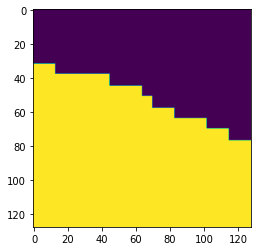

In [ ]:
mask = np.array([erosion(thresholded[i, ...]) for i in range(original_shape[0])])
weights = np.array(
    [
        img_shadow_corrs[0] < thresholds[0][0],
        mask,
    ]
).astype(np.float32)
del mask
del thresholded
plt.imshow(weights[1, 100, 10])

In [ ]:
print(weights.shape)
print(weights.dtype)

(2, 640, 21, 128, 128)
float32


# Background estimation

In [ ]:
background_dir = path.join(path.dirname(file_path), "BaSiCPy_results")
os.makedirs(background_dir, exist_ok=True)

In [ ]:
smoothness_flatfield = 1
for c in range(img.shape[2]):
    b = BaSiC(
        get_darkfield=False,
        working_size=None,
        smoothness_flatfield=smoothness_flatfield,
    )
    im = img_shadow_corrs[c]
    print(im.shape)
    b.fit(im, fitting_weight=weights[c])
    for z in range(img.shape[-3]):
        print(b.flatfield.shape)
        plt.title(
            f"{img.channel_names[c]} z={z} lambda_flatfield_coef={lambda_flatfield_coef}"
        )
        plt.imshow(b.flatfield[z])
        plt.show()
        plt.imshow(b.darkfield[z])
        plt.title(
            f"{img.channel_names[c]} z={z} lambda_flatfield_coef={lambda_flatfield_coef}"
        )
        plt.show()
    b.save_model(
        path.join(
            background_dir,
            f"basic_{img.channel_names[c]}_lambda_flatfield_coef{lambda_flatfield_coef}",
        )
    )

(640, 21, 128, 128)


XlaRuntimeError: ignored

In [ ]:
BaSiC

# Stitching 

(please restart the runtime here to avoid memory overflow)

In [ ]:
background_dir = path.join(path.dirname(file_path), "BaSiCPy_results")
basics = [
    BaSiC.load_model(path.join(background_dir, "basic_Ch1_lambda_flatfield_coef30")),
    BaSiC.load_model(path.join(background_dir, "basic_T PMT_lambda_flatfield_coef30")),
]

In [ ]:
mosaic_poss = np.array([img.get_mosaic_tile_position(m) for m in range(img.shape[0])])
mosaic_poss[:, 0] = mosaic_poss[:, 0] - np.min(mosaic_poss[:, 0])
mosaic_poss[:, 1] = mosaic_poss[:, 1] - np.min(mosaic_poss[:, 1])
mosaic_poss

In [ ]:
stitched_image = np.zeros(
    list(img.shape[1:-2])
    + [
        img.shape[-2] + np.max(mosaic_poss[:, 0]),
        img.shape[-1] + np.max(mosaic_poss[:, 1]),
    ]
)
for m in range(img.shape[0]):
    mp = mosaic_poss[m]
    stitched_image[
        ..., mp[0] : mp[0] + img.shape[-2], mp[1] : mp[1] + img.shape[-1]
    ] = img.dask_data[m, ...]

In [ ]:
stitched_image2 = np.zeros(
    list(img.shape[1:-2])
    + [
        img.shape[-2] + np.max(mosaic_poss[:, 0]),
        img.shape[-1] + np.max(mosaic_poss[:, 1]),
    ]
)
for m in range(img.shape[0]):
    mp = mosaic_poss[m]
    for c in range(img.shape[2]):
        b = basics[c]
        stitched_image2[
            :, c, ..., mp[0] : mp[0] + img.shape[-2], mp[1] : mp[1] + img.shape[-1]
        ] = [img.dask_data[m, t, c] / b.flatfield for t in range(img.shape[1])]

In [ ]:
zs = np.arange(0, 21, 5)
zs

In [ ]:
import os

os.makedirs("stitched_examples", exist_ok=True)
for c in range(img.shape[2]):
    for z in zs:
        plt.imshow(
            stitched_image[0, c, z],
            vmin=[5, 0][c],
            vmax=[30, 100][c],
        )
        plt.axis(False)
        plt.savefig(f"stitched_examples/uncorrected_{c}_{z}.png")
        plt.show()

In [ ]:
os.makedirs("stitched_examples", exist_ok=True)
for c in range(img.shape[2]):
    for z in zs:
        plt.imshow(
            stitched_image2[0, c, z],
            vmin=[5, 0][c],
            vmax=[30, 100][c],
        )
        plt.axis(False)
        plt.savefig(f"stitched_examples/corrected_{c}_{z}.png")
        plt.show()

In [ ]:
b = basics[0]
for z in range(20):
    plt.imshow(b.flatfield[z], vmin=0.5, vmax=1.4)
    plt.show()